# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining Experimental Params

In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

## Initalisation used

In [4]:
config["operator_params"]["operator"] = "RandomOcclude"
config["operator_params"]["num_measurements"] = 200

## Baseline of 0

In [5]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

## Different measurements

In [6]:
config["estimator_params"]["initalisation"] = "posterior"
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 50
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["exp_params"]["batch_size"] = 100
dm = mnist_dataloader_test(config, path=path)

In [9]:
posterior = []
error_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    posterior.append(e_x)
    error_posterior.append(std)

100%|██████████| 15/15 [03:28<00:00, 13.88s/it]


In [10]:
config["estimator_params"]["initalisation"] = "random"

In [11]:
random = []
error_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

100%|██████████| 15/15 [03:21<00:00, 13.46s/it]


In [12]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 10
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [13]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

100%|██████████| 15/15 [04:11<00:00, 16.74s/it]


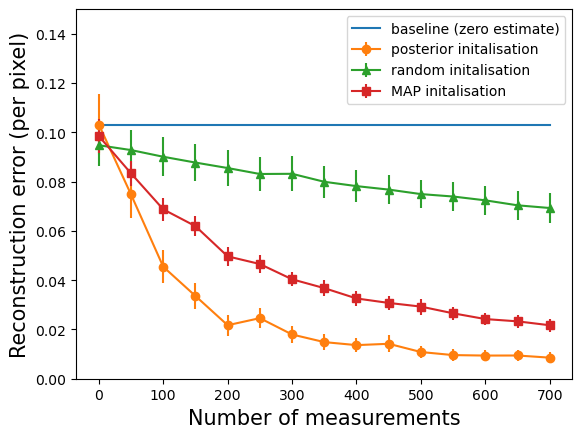

In [14]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), posterior, yerr=error_posterior, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), random, yerr=error_random, fmt='-^')
plt.errorbar(list(range(0, 750, 50)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.legend(['baseline (zero estimate)','posterior initalisation', 'random initalisation', 'MAP initalisation'])
plt.show()

## Different burn-in 

In [35]:
config["estimator_params"]["initalisation"] = "posterior"
config['estimator_params']['potential'] = "mse"
config['estimator_params']['lambda_score'] = 50
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["exp_params"]["batch_size"] = 100
config['estimator_params']['lambda'] = 500
dm = mnist_dataloader_test(config, path=path)

In [37]:
posterior = []
error_posterior = []
for num in trange(0, 140, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    #ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    posterior.append(e_x)
    error_posterior.append(std)

100%|██████████| 7/7 [02:24<00:00, 20.68s/it]


In [38]:
config["estimator_params"]["initalisation"] = "random"
config['estimator_params']['potential'] = "mse"
config['estimator_params']['lambda_score'] = 50
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config['estimator_params']['lambda'] = 500

In [39]:
random = []
error_random = []
for num in trange(0, 140, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    #ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

100%|██████████| 7/7 [02:25<00:00, 20.71s/it]


In [40]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1
config['estimator_params']['potential'] = "mse"
config['estimator_params']['lambda_score'] = 50
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config['estimator_params']['lambda'] = 500

In [41]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 140, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    #ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

100%|██████████| 7/7 [05:06<00:00, 43.82s/it]


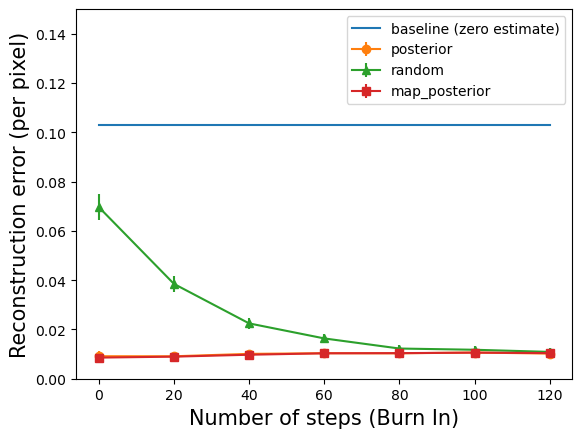

In [29]:
plt.xlabel('Number of steps (Burn In)', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 140, 20)), [baseline]*7)
plt.errorbar(list(range(0, 140, 20)), posterior, yerr=error_posterior, fmt='-o')
plt.errorbar(list(range(0, 140, 20)), random, yerr=error_random, fmt='-^')
plt.errorbar(list(range(0, 140, 20)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.legend(['baseline (zero estimate)','posterior', 'random', 'map_posterior'])
plt.show()

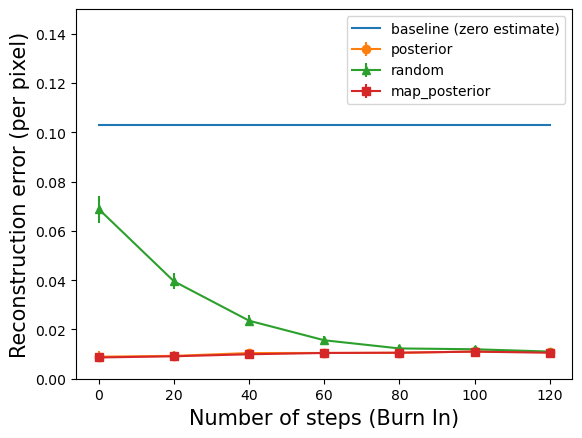

In [42]:
plt.xlabel('Number of steps (Burn In)', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 140, 20)), [baseline]*7)
plt.errorbar(list(range(0, 140, 20)), posterior, yerr=error_posterior, fmt='-o')
plt.errorbar(list(range(0, 140, 20)), random, yerr=error_random, fmt='-^')
plt.errorbar(list(range(0, 140, 20)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.legend(['baseline (zero estimate)','posterior', 'random', 'map_posterior'])
plt.show()

In [43]:
posterior

[tensor(0.0089),
 tensor(0.0093),
 tensor(0.0104),
 tensor(0.0105),
 tensor(0.0105),
 tensor(0.0111),
 tensor(0.0108)]

In [44]:
map_posterior

[tensor(0.0086),
 tensor(0.0091),
 tensor(0.0099),
 tensor(0.0104),
 tensor(0.0106),
 tensor(0.0110),
 tensor(0.0106)]